<a href="https://colab.research.google.com/github/EdWangLoDaSc/Physical-based-Spatial-time-series-Prediction/blob/main/dataset_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Standard library imports
import math
import pickle
import random
import time

# Third-party library imports
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.interpolate import griddata
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage.metrics import structural_similarity as ssim


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def x_to_y(X): # averaging in 2*2 windows (4 pixels)
    dim = X.shape[0]
    dim = 20
    Y = np.zeros((int(dim/2),int(dim/2)))
    for i in range(int(dim/2)):
        for j in range(int(dim/2)):
            Y[i,j] = X[2*i,2*j] + X[2*i+1,2*j] + X[2*i,2*j+1] + X[2*i+1,2*j+1]

            Y_noise = np.random.multivariate_normal(np.zeros(100),0.0000 * np.eye(100))
            Y_noise.shape = (10,10)
            Y = Y + Y_noise
    return Y


class shallow(object):

    time = 0

    plt = []
    fig = []


    def __init__(self, x=[],y=[],h_ini = 1.,u=[],v = [],dx=0.01,dt=0.0001, N=64,L=1., px=16, py=16, R=64, Hp=0.1, g=1., b=0.): # How define no default argument before?


        # add a perturbation in pressure surface


        self.px, self.py = px, py
        self.R = R
        self.Hp = Hp



        # Physical parameters

        self.g = g
        self.b = b
        self.L=L
        self.N=N

        self.dx=dx
        self.dt=dt

        self.x,self.y = mgrid[:self.N,:self.N]

        self.u=zeros((self.N,self.N))
        self.v=zeros((self.N,self.N))

        self.h_ini=h_ini

        self.h=self.h_ini * ones((self.N,self.N))

        rr = (self.x-px)**2 + (self.y-py)**2
        self.h[rr<R] = self.h_ini + Hp #set initial conditions

        self.lims = [(self.h_ini-self.Hp,self.h_ini+self.Hp),(-0.02,0.02),(-0.02,0.02)]



    def dxy(self, A, axis=0):
        """
        Compute derivative of array A using balanced finite differences
        Axis specifies direction of spatial derivative (d/dx or d/dy)
        dA[i]/dx =  (A[i+1] - A[i-1] )  / 2dx
        """
        return (roll(A, -1, axis) - roll(A, 1, axis)) / (self.dx*2.) # roll: shift the array axis=0 shift the horizontal axis

    def d_dx(self, A):
        return self.dxy(A,1)

    def d_dy(self, A):
        return self.dxy(A,0)


    def d_dt(self, h, u, v):
        """
        http://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form
        """
        for x in [h, u, v]: # type check
           assert isinstance(x, ndarray) and not isinstance(x, matrix)

        g,b,dx = self.g, self.b, self.dx

        du_dt = -g*self.d_dx(h) - b*u
        dv_dt = -g*self.d_dy(h) - b*v

        H = 0 #h.mean() - our definition of h includes this term
        dh_dt = -self.d_dx(u * (H+h)) - self.d_dy(v * (H+h))

        return dh_dt, du_dt, dv_dt


    def evolve(self):
        """
        Evolve state (h, u, v) forward in time using simple Euler method
        x_{N+1} = x_{N} +   dx/dt * d_t
        """

        dh_dt, du_dt, dv_dt = self.d_dt(self.h, self.u, self.v)
        dt = self.dt

        self.h += dh_dt * dt
        self.u += du_dt * dt
        self.v += dv_dt * dt
        self.time += dt

        return self.h, self.u, self.v

In [4]:
import random as rand
def simu(iteration_times, Hp, R, n_steps,blank_steps, px, py):
    SW = shallow(N=64, px=px, py=py, R=R, Hp=Hp, b=0.2)
    num = (iteration_times - blank_steps) // n_steps
    true_u_vect = np.zeros((num, SW.N, SW.N))
    true_v_vect = np.zeros((num, SW.N, SW.N))
    true_h_vect = np.zeros((num, SW.N, SW.N))
    index = 0

    for i in range(iteration_times):
        SW.evolve()

        if i % n_steps == 0 and i >= 500:
            true_u_vect[index], true_v_vect[index], true_h_vect[index] = SW.u, SW.v, SW.h
            index += 1

    return true_u_vect, true_v_vect, true_h_vect


def structure_obs(N, random_range):
    x = np.arange(0, N, 5)
    y = np.arange(0, N, 5)
    x_list, y_list = np.meshgrid(x, y)

    x_coord = np.empty(x_list.size, dtype=int)
    y_coord = np.empty(y_list.size, dtype=int)

    for i, (x_val, y_val) in enumerate(zip(x_list.flatten(), y_list.flatten())):
        if (i+1) % 64 != 0:
            x_val += rand.randint(0, random_range)
            y_val += rand.randint(0, random_range)

        x_coord[i] = x_val if x_val < N else N - 1
        y_coord[i] = y_val if y_val < N else N - 1

    return x_coord, y_coord

In [14]:
random.seed(1)
second_element_range = (0.4, 1)
third_element_range = (4, 8)

# Number of random tuples to generate
num_random_tuples = 150
steps = 3500
blank_steps = 500
px = 32
py = 32
# Generate random tuples
sim_params = [(steps,
               round(random.uniform(*second_element_range), 2),
               random.randint(*third_element_range),
               10,
               blank_steps,
               px,#np.random.randint(30, 34),  # px
               py)#random.randint(30, 34))  # py
              for _ in range(num_random_tuples)]
# Simulate data and stack the results
def simulate_and_stack(sim_params):
    true_u_vect, true_v_vect, true_h_vect = [], [], []
    for nsteps, hp, r, n,blank,px,py in sim_params:
        u, v, h = simu(nsteps, hp, r**2, n,blank,px,py)
        true_u_vect.append(u)
        true_v_vect.append(v)
        true_h_vect.append(h)

    true_u_vect = np.vstack(true_u_vect)
    true_v_vect = np.vstack(true_v_vect)
    true_h_vect = np.vstack(true_h_vect)

    return true_u_vect, true_v_vect, true_h_vect

# Simulate data and stack the results
true_u_vect, true_v_vect, true_h_vect = simulate_and_stack(sim_params)

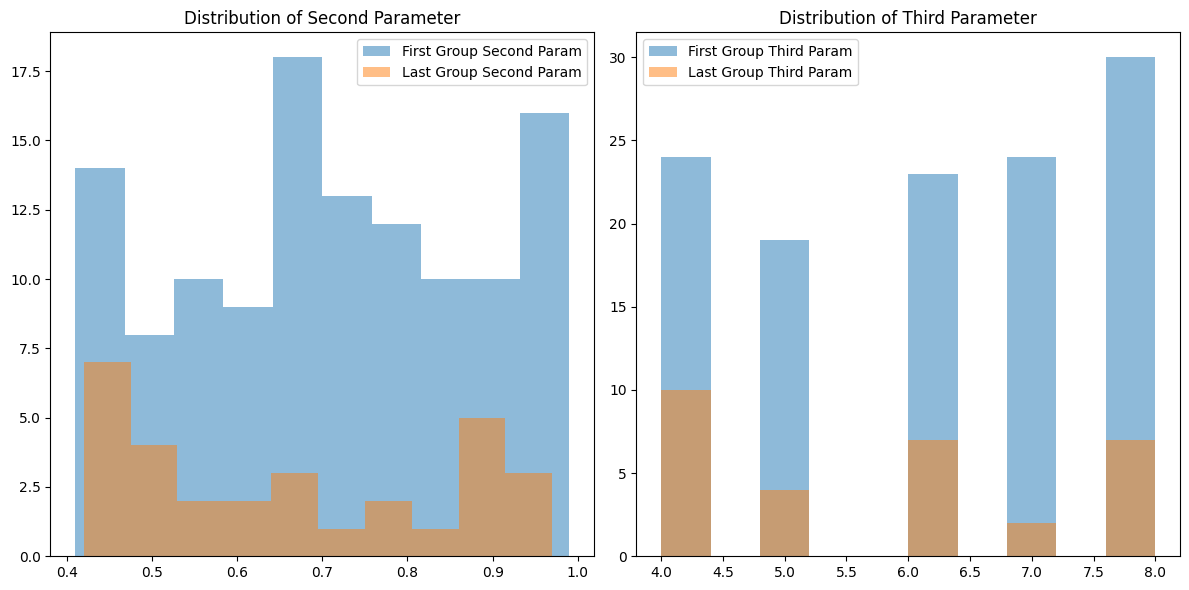

(KstestResult(statistic=0.24166666666666667, pvalue=0.109660202343656, statistic_location=0.53, statistic_sign=-1),
 KstestResult(statistic=0.15, pvalue=0.6234534840502581, statistic_location=6, statistic_sign=-1))

In [19]:
first_params = sim_params[:120]  # Adjusted for demonstration
last_params = sim_params[-30:]  # Adjusted for demonstration

# Extracting second and third parameters
first_second_param = [param[1] for param in first_params]
first_third_param = [param[2] for param in first_params]
last_second_param = [param[1] for param in last_params]
last_third_param = [param[2] for param in last_params]

# Statistical analysis (Kolmogorov-Smirnov test for comparing distributions)
ks_2nd_param = stats.ks_2samp(first_second_param, last_second_param)
ks_3rd_param = stats.ks_2samp(first_third_param, last_third_param)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting distributions of the second parameter
axs[0].hist(first_second_param, alpha=0.5, label='First Group Second Param')
axs[0].hist(last_second_param, alpha=0.5, label='Last Group Second Param')
axs[0].set_title('Distribution of Second Parameter')
axs[0].legend()

# Plotting distributions of the third parameter
axs[1].hist(first_third_param, alpha=0.5, label='First Group Third Param')
axs[1].hist(last_third_param, alpha=0.5, label='Last Group Third Param')
axs[1].set_title('Distribution of Third Parameter')
axs[1].legend()

plt.tight_layout()
plt.show()

ks_2nd_param, ks_3rd_param


In [20]:
np.save('/content/drive/MyDrive/Physics/Physics/Dataset10/true_u_full.npy',true_u_vect)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset10/true_v_full.npy',true_v_vect)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset10/true_h_full.npy',true_h_vect)
del true_u_vect,true_v_vect,true_h_vect

In [21]:
true_u_vect = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/true_u_full.npy', mmap_mode="r")
true_v_vect = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/true_v_full.npy', mmap_mode="r")
true_h_vect = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/true_h_full.npy', mmap_mode="r")

a = 300*150


# Constants
N = 64
datasize = int(a)  # Ensure 'a' is defined earlier in your code

# Initialize arrays
true_data = np.zeros((datasize, N, N, 3))  # Combining u, v, h data into one array for simplicity
vor_data = np.zeros((datasize, N, N, 3))

# Grid preparation
x, y = np.linspace(0., N, N), np.linspace(0., N, N)[::-1]
X, Y = np.meshgrid(x, y)
P = np.column_stack((X.flatten(), Y.flatten()))

# Data processing and conditional plotting
for index in range(datasize):
    for vect, slice_idx in zip([true_u_vect, true_v_vect, true_h_vect], range(3)):
        x_coord, y_coord = structure_obs(64, 2)
        Zi = vect[index, x_coord.astype(int), N-1-y_coord.astype(int)]
        Pi = np.column_stack((x_coord, y_coord))
        Z_nearest = griddata(Pi, Zi, P, method="nearest").reshape([N, N])
        vor_data[index, :, :, slice_idx] = Z_nearest
        true_data[index, :, :, slice_idx] = vect[index, :, :]

'''    # Conditional plotting for specified indices
    if index in plot_indices:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

        # Plotting Voronoi "u" data
        axs[0].imshow(vor_data[index, :, :, 1])
        axs[0].scatter(x_coord, N - 1 - y_coord, c='red', s=60)

        # Plotting True "u" data
        axs[1].imshow(true_data[index, :, :, 0])
        axs[1].scatter(x_coord, N - 1 - y_coord, c='red', s=60)
        plt.show()'''
# Correcting the data swap issue
vor_u_data, vor_v_data = vor_data[..., 0], vor_data[..., 1]
vor_h_data, true_u_data = vor_data[..., 2], true_data[..., 0]
true_v_data, true_h_data = true_data[..., 1], true_data[..., 2]

print(true_u_data.shape)
print(true_u_vect.shape)
# Save data
np.save('/content/drive/MyDrive/Physics/Physics/Dataset10/vor_u_full.npy', vor_u_data)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset10/vor_v_full.npy', vor_v_data)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset10/vor_h_full.npy', vor_h_data)


# Clean up
del vor_u_data, vor_v_data, vor_h_data, true_u_data, true_v_data, true_h_data
del true_u_vect, true_v_vect, true_h_vect


(45000, 64, 64)
(45000, 64, 64)


In [22]:
vor_u_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/vor_u_full.npy', mmap_mode="r")
vor_v_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/vor_v_full.npy', mmap_mode="r")
vor_h_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/vor_h_full.npy', mmap_mode="r")
true_v_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/true_v_full.npy', mmap_mode="r")
true_u_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/true_u_full.npy', mmap_mode="r")
true_h_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset10/true_h_full.npy', mmap_mode="r")

datasize = 300*150
# Create train and test indices
train_rate = 0.80
train_index = np.arange(0, int(datasize * train_rate))
test_index = np.arange(train_index[-1] + 1, datasize)

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data,vor_h_data]
true_data = [true_v_data,true_u_data,true_h_data]

# Initialize lists to store the split datasets
vor_train, vor_test, true_train, true_test = [], [], [], []

# Processing loop
for vor, true in zip(vor_data, true_data):
    # Split vor data
    vor_train.append(vor[train_index])
    vor_test.append(vor[test_index])

    # Split true data
    true_train.append(true[train_index])
    true_test.append(true[test_index])

# Final concatenation
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)

In [23]:
import os

# Directory to save the files
save_dir = '/content/drive/MyDrive/Physics/Physics/Dataset10'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the arrays
np.save(os.path.join(save_dir, 'vor_train.npy'), vor_train)
np.save(os.path.join(save_dir, 'true_train.npy'), true_train)
np.save(os.path.join(save_dir, 'vor_test.npy'), vor_test)
np.save(os.path.join(save_dir, 'true_test.npy'), true_test)

del vor_train,true_train,vor_test,true_test

In [ ]:
vor_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_test.npy', mmap_mode="r")

vor_image = np.vstack([vor_train,vor_test])
true_image = np.vstack([true_train,true_test])